In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras import models

In [2]:
CATEGORIES = ['Black-grass',
          'Charlock',
          'Cleavers',
          'Common Chickweed',
          'Common wheat',
          'Fat Hen',
          'Loose Silky-bent',
          'Maize',
          'Scentless Mayweed',
          'Shepherds Purse',
          'Small-flowered Cranesbill',
          'Sugar beet']

IMG_SIZE=300

DATADIR  = 'D:/project/dataset/train'
DATADIR_TEST  = 'D:/project/dataset/test'

In [3]:
TRAIN_DATA_DIR = DATADIR
batch_size = 16
# create data generators
def data_generators():

    # apply random transformations on training data
    train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=180,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        validation_split = 0.1,
    )
    test_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(
      preprocessing_function=preprocess_input)
    
    train_gen = train_data_generator.flow_from_directory(
        directory = TRAIN_DATA_DIR,
        target_size = (IMG_SIZE, IMG_SIZE),
        color_mode = 'rgb',
        class_mode = "categorical",
        batch_size = batch_size,
        subset = 'training',
    )

    # define validation data generator
    validation_gen = train_data_generator.flow_from_directory(
        directory = TRAIN_DATA_DIR,
        color_mode = 'rgb',
        class_mode = "categorical",
        target_size = (IMG_SIZE, IMG_SIZE),
        batch_size = batch_size,
        subset = 'validation',
        shuffle=False
    )
    test_gen = test_data_generator.flow_from_directory(
        directory= 'D:/project/dataset',
        classes=['test'],
        target_size=(IMG_SIZE, IMG_SIZE),
        batch_size=1,
        color_mode='rgb',
        shuffle=False,
        class_mode='categorical')
    return train_gen, validation_gen, test_gen
train_gen, validation_gen, test_gen = data_generators()

Found 4279 images belonging to 12 classes.
Found 471 images belonging to 12 classes.
Found 794 images belonging to 1 classes.


In [4]:
print(train_gen.class_indices)

{'Black-grass': 0, 'Charlock': 1, 'Cleavers': 2, 'Common Chickweed': 3, 'Common wheat': 4, 'Fat Hen': 5, 'Loose Silky-bent': 6, 'Maize': 7, 'Scentless Mayweed': 8, 'Shepherds Purse': 9, 'Small-flowered Cranesbill': 10, 'Sugar beet': 11}


In [5]:
resnet_model = Sequential()
pretrained_model=ResNet50(include_top = False, pooling = 'avg', input_shape=(IMG_SIZE, IMG_SIZE, 3), weights = 'imagenet')

In [6]:
for layer in pretrained_model.layers[:160]:
        layer.trainable = False
for layer in pretrained_model.layers[160:]:
        layer.trainable = True
resnet_model = Sequential()
resnet_model.add(pretrained_model)
resnet_model.add(Flatten())
resnet_model.add(Dense(1024,"relu"))
resnet_model.add(Dense(512,"relu"))
resnet_model.add(Dense(128,"relu"))
resnet_model.add(Dense(12, activation ='softmax'))

In [7]:
resnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 128)               65664     
                                                                 
 dense_3 (Dense)             (None, 12)                1548      
                                                                 
Total params: 26,277,900
Trainable params: 8,210,572
N

In [8]:
resnet_model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [9]:
# save best model regularly
save_best_model = tf.keras.callbacks.ModelCheckpoint(filepath = 'best.h5',monitor = 'val_accuracy', 
                                                     save_best_only = True, verbose = 1,mode='max')
# reduce learning rate when it stops decreasing
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.4,patience = 3,
                                                 min_lr = 1e-10, verbose = 1, cooldown = 1)
# stop training early if no further improvement
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', min_delta = 1e-2, patience = 10, verbose = 1,
        mode = 'max', baseline = None, restore_best_weights = True)
callback=[save_best_model, reduce_lr, early_stopping]

In [10]:
history = resnet_model.fit(train_gen,
          epochs = 100,
          steps_per_epoch=train_gen.samples // batch_size,
          validation_data = validation_gen,
          validation_steps = validation_gen.samples // batch_size,
          callbacks=callback)

Epoch 1/100
267/267 [==============================] - ETA: 0s - loss: 1.0411 - accuracy: 0.6531
Epoch 1: val_accuracy improved from -inf to 0.75431, saving model to best.h5
267/267 [==============================] - 497s 2s/step - loss: 1.0411 - accuracy: 0.6531 - val_loss: 0.9358 - val_accuracy: 0.7543 - lr: 0.0010
Epoch 2/100
267/267 [==============================] - ETA: 0s - loss: 0.5431 - accuracy: 0.8201
Epoch 2: val_accuracy improved from 0.75431 to 0.79957, saving model to best.h5
267/267 [==============================] - 509s 2s/step - loss: 0.5431 - accuracy: 0.8201 - val_loss: 0.5945 - val_accuracy: 0.7996 - lr: 0.0010
Epoch 3/100
267/267 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.8496
Epoch 3: val_accuracy improved from 0.79957 to 0.82543, saving model to best.h5
267/267 [==============================] - 481s 2s/step - loss: 0.4589 - accuracy: 0.8496 - val_loss: 0.5108 - val_accuracy: 0.8254 - lr: 0.0010
Epoch 4/100
267/267 [================

Epoch 27/100
267/267 [==============================] - ETA: 0s - loss: 0.0723 - accuracy: 0.9740
Epoch 27: val_accuracy did not improve from 0.94612
267/267 [==============================] - 497s 2s/step - loss: 0.0723 - accuracy: 0.9740 - val_loss: 0.2243 - val_accuracy: 0.9375 - lr: 6.4000e-05
Epoch 28/100
267/267 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9761
Epoch 28: val_accuracy did not improve from 0.94612
267/267 [==============================] - 470s 2s/step - loss: 0.0707 - accuracy: 0.9761 - val_loss: 0.2114 - val_accuracy: 0.9375 - lr: 6.4000e-05
Epoch 29/100
267/267 [==============================] - ETA: 0s - loss: 0.0683 - accuracy: 0.9763
Epoch 29: val_accuracy improved from 0.94612 to 0.94828, saving model to best.h5
Restoring model weights from the end of the best epoch: 19.
267/267 [==============================] - 449s 2s/step - loss: 0.0683 - accuracy: 0.9763 - val_loss: 0.2065 - val_accuracy: 0.9483 - lr: 6.4000e-05
Epoch 29: earl

In [11]:
model = models.load_model('best.h5')

In [12]:
model.evaluate(test_gen)

794/794 [==============================] - 88s 111ms/step - loss: 265.1017 - accuracy: 0.0554


[265.10174560546875, 0.05541561543941498]

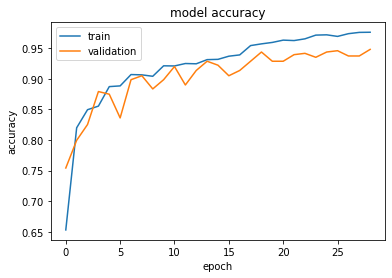

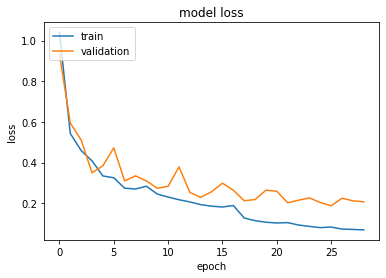

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

In [15]:
Y_pred = model.predict_generator( validation_gen, validation_gen.samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_gen.classes, y_pred))

C:\Users\farhe\AppData\Local\Temp\ipykernel_14312\3071142573.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  Y_pred = model.predict_generator( validation_gen, validation_gen.samples // batch_size+1)


Confusion Matrix
[[20  0  0  0  0  0  6  0  0  0  0  0]
 [ 0 38  0  0  0  0  0  0  0  0  0  1]
 [ 0  1 25  0  1  0  0  0  0  1  0  0]
 [ 0  0  0 60  0  0  0  0  1  0  0  0]
 [ 0  0  0  0 22  0  0  0  0  0  0  0]
 [ 0  0  0  1  0 45  0  0  0  0  0  1]
 [ 2  0  0  0  0  0 63  0  0  0  0  0]
 [ 1  0  0  0  0  0  0 20  0  0  0  1]
 [ 0  0  0  0  0  0  0  0 50  1  0  0]
 [ 0  0  0  0  0  0  0  0  3 20  0  0]
 [ 0  0  0  0  0  0  0  0  1  0 48  0]
 [ 0  1  0  0  0  0  1  0  0  0  0 36]]


In [16]:
print('Classification Report')
print(classification_report(validation_gen.classes, y_pred, target_names=CATEGORIES))

Classification Report
                           precision    recall  f1-score   support

              Black-grass       0.87      0.77      0.82        26
                 Charlock       0.95      0.97      0.96        39
                 Cleavers       1.00      0.89      0.94        28
         Common Chickweed       0.98      0.98      0.98        61
             Common wheat       0.96      1.00      0.98        22
                  Fat Hen       1.00      0.96      0.98        47
         Loose Silky-bent       0.90      0.97      0.93        65
                    Maize       1.00      0.91      0.95        22
        Scentless Mayweed       0.91      0.98      0.94        51
          Shepherds Purse       0.91      0.87      0.89        23
Small-flowered Cranesbill       1.00      0.98      0.99        49
               Sugar beet       0.92      0.95      0.94        38

                 accuracy                           0.95       471
                macro avg       0.95  